# Finding regions under selection

## [paper title]


breif description

In [34]:
import scipy.stats
#import statsmodels.api as sm
#import statsmodels as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import allel
import shutil
import math
import yaml
import pandas as pd
from intervaltree import IntervalTree
from collections import defaultdict
from scipy import stats
from scipy import signal
import pybedtools
import gffutils
import itertools
from tqdm import tqdm
import random

os.chdir("/master/nplatt/sch_man_nwinvasion")

Calculate the cumulative length fo each chromosome for downstream plotting

In [7]:
#make sure that all stops are not gt chrom length
chr_length = {}
#genome_size = 0
with open('/master/nplatt/sch_man_nwinvasion/data/genomes/Smansoni_v7.fa.fai', 'r') as fai:
    for entry in fai:
        chrom, length, *offset = entry.rstrip().split("\t")
        chr_length[chrom]=int(length)

    cumul_start={}
    cumul_start['SM_V7_1']=0
    cumul_start['SM_V7_2']= cumul_start['SM_V7_1'] + chr_length['SM_V7_1']
    cumul_start['SM_V7_3']= cumul_start['SM_V7_2'] + chr_length['SM_V7_2']
    cumul_start['SM_V7_4']= cumul_start['SM_V7_3'] + chr_length['SM_V7_3']
    cumul_start['SM_V7_5']= cumul_start['SM_V7_4'] + chr_length['SM_V7_4']
    cumul_start['SM_V7_6']= cumul_start['SM_V7_5'] + chr_length['SM_V7_5']
    cumul_start['SM_V7_7']= cumul_start['SM_V7_6'] + chr_length['SM_V7_6']
    scanned_size = cumul_start['SM_V7_7'] + chr_length['SM_V7_7']

In [8]:
#read in vcf file
filtered_callset=allel.read_vcf('results/variant_filtration/smv7_ex_autosomes.vcf')

# msprime 

breif description

In [35]:
%%bash

mkdir -p results/msprime/logs

CONDA="conda activate sch_man_nwinvasion-msprime;"
QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 1 "    

for POP in tanzania senegal niger brazil; do
    mkdir results/msprime/$POP
    for I in $(seq 1 100); do
        MSPRIME_CMD="python code/msprime-qsub.py $POP $I"       
        echo "$CONDA $MSPRIME_CMD" | $QSUB -N $POP"_"$I -o results/msprime/logs/$POP"_"$I.log
    done
done


#--------------------------------------------------------------------------------------------------------
# msprime-qsub.py
#--------------------------------------------------------------------------------------------------------

# import msprime
# import os
# import subprocess
# import sys
# from random import randint

# pop = sys.argv[1]
# iteration = sys.argv[2]

# #################################
# def sim_tree(iteration, pop, length, recomb_rate, mut_rate, seed):
    
#     tree_sequence = msprime.simulate( sample_size=n_samples[pop], 
#         Ne=ne[pop], 
#         length=88.9e6, 
#         recombination_rate=3.4e-8,
#         mutation_rate=8.1e-9,
#         random_seed=seed)

#     print("iter {}: {} completed".format(iteration, pop))
#     #print(tree.draw(format="unicode"))

#     with open("results/msprime/{}/chr1_{}_rep_{}_seed_{}.vcf".format(pop, pop, iteration, seed), "w") as vcf_file:
#         tree_sequence.write_vcf(vcf_file, ploidy=2)
# ########################################

# #calcualted by est_pop_params.py
# ne = { "brazil"      : 18293,
#        "niger"       : 19971,
#        "senegal"     : 22421,
#        "tanzania"    : 52234 }

# n_samples = { "brazil"   : 48*2,
#               "senegal"  : 25*2,
#               "niger"    : 10*2,
#               "tanzania" : 58*2  }

# seed = randint(0,1e6)
# sim_tree(iteration, pop, 88e-9, 3.4e-8, 8.1e-9, seed)

Your job 5672368 ("tanzania_1") has been submitted
Your job 5672369 ("tanzania_2") has been submitted
Your job 5672370 ("tanzania_3") has been submitted
Your job 5672371 ("tanzania_4") has been submitted
Your job 5672372 ("tanzania_5") has been submitted
Your job 5672373 ("tanzania_6") has been submitted
Your job 5672374 ("tanzania_7") has been submitted
Your job 5672375 ("tanzania_8") has been submitted
Your job 5672376 ("tanzania_9") has been submitted
Your job 5672377 ("tanzania_10") has been submitted
Your job 5672378 ("tanzania_11") has been submitted
Your job 5672379 ("tanzania_12") has been submitted
Your job 5672380 ("tanzania_13") has been submitted
Your job 5672381 ("tanzania_14") has been submitted
Your job 5672382 ("tanzania_15") has been submitted
Your job 5672383 ("tanzania_16") has been submitted
Your job 5672384 ("tanzania_17") has been submitted
Your job 5672385 ("tanzania_18") has been submitted
Your job 5672386 ("tanzania_19") has been submitted
Your job 5672387 ("ta

Now after all the jobs have finished the through the scheudler take each simulated chrom and extract only the snps that fall within exome-probed regions

In [ ]:
#--------------------------------------------------------------------------------------------------------
# msprime-probe_snps_from_vcf.py
#--------------------------------------------------------------------------------------------------------

import msprime
import os
import subprocess
import glob


#now create bed for the new "sim" chr1
with open('data/renamed-sma_agilent_baits.v7.0.chr_reorderd.bed', 'r') as in_bed:
    with open('results/msprime/sim_probes.bed', 'w') as out_bed:
        for bed_entry in in_bed:
            chrom, start, stop = bed_entry.rstrip().split("\t")
            if chrom == "SM_V7_1":
                out_bed.write("1\t{}\t{}\n".format(start, stop))

bed = 'results/msprime/sim_probes.bed'
#now loop through all of the sim vcf files to get snps at probed regions
for pop in ["niger", "senegal", "tanzania", "brazil"]:
    out_dir = "results/msprime/{}".format(pop)
    
    sim_vcfs = glob.glob("{}/chr1_*_rep_*.vcf".format(out_dir))
    for sim_vcf in sim_vcfs:

        probed_vcf = sim_vcf.replace(".vcf", "_probed.vcf")         
        jid = "probe_{}".format(probed_vcf.split("/")[-1])
        log = "{}/logs".format(out_dir)

        vcf_cmd = "vcftools --vcf {} --bed {} --recode --recode-INFO-all --stdout >{}".format(sim_vcf, bed, probed_vcf)
        qsub_cmd =  "qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 3 -N {} -o {}".format(jid, log)
        conda_cmd = "conda activate sch_man_nwinvasion-msprime"

        cmd ="echo \"{}; {}\" | {}".format(conda_cmd, vcf_cmd, qsub_cmd)

        #run vcf cmd
        #process = subprocess.Popen(cmd.split(""),
        #                     stdout=subprocess.PIPE, 
        #                     stderr=subprocess.PIPE)
        !{cmd}

# H-scan

HSCAN identifies regions under selection based on the length of haplotypes.  (citation).  We used a custom code to convert HSCAN to VCF input formats.

Run on actual data with:
```code/hscan-run_with_real_data.sh```

Repeat the process on simulated data:

```code/hscan-run_with_sim_data.sh```

Once those analyses are finished come back here to process the results

In [38]:
#% bash

#code/hscan-run_with_real_data.sh
#code/hscan-run_with_sim_data.sh

## Combine runs, smooth H, and generate a .csv file

In [28]:
#SET WINDOW SMOOTHING SIZE HERE
window=201

In [29]:
#cycle through each population to calculate generate csv file with H scores, etc. 
for pop in ["niger", "senegal", "brazil", "tanzania"]:

    print(pop)

    #make sure lists are clean
    chrom_s=[]
    pos_s=[]
    h_s=[]
    smoothed_h_s=np.array([])

    #read all the hscan output for the population into lists for chrom, h, and pos
    for i in range(1,8):
        tmp_chr_h_s=[]

        chrom = "SM_V7_{}".format(i)
        
        with open("results/hscan/{}/{}_{}.hscan-out".format(pop, chrom, pop), 'r') as hscan_file:
            #skip the header line
            next(hscan_file)
            
            for calc in hscan_file:
                
                pos, h = calc.rstrip().split("\t")
                
                chrom_s.append(chrom)
                tmp_chr_h_s.append(h)
                h_s.append(h)
                pos_s.append(pos)

        #smooth the h_s for this chromosome and add to an array
        smoothed_h=scipy.signal.medfilt(np.array(tmp_chr_h_s).astype(float), window)
        smoothed_h_s=np.append(smoothed_h_s, smoothed_h)

    #convert the lists to numpy arrays
    chrom_s=np.array(chrom_s)
    pos_s=np.array(pos_s)
    h_s=np.array(h_s).astype(np.float)
    
    #now add all info to a data table
    columns = ["chrom", "pos", "h", "smoothed_h"]
    df = pd.DataFrame(data = [chrom_s, pos_s, h_s, smoothed_h_s]).T
    df.columns=columns

    #get cumulative positions along the genome (additive positions; used to easily organize data in chr order)
    fig_x_pos_s=[]
    for index, row in df.iterrows(): 
        fig_x_pos_s.append(int(row["pos"]) + int(cumul_start[row['chrom']]))

    df['fig_x_pos']=fig_x_pos_s
    df = df.sort_values(["fig_x_pos"], ascending = True)

    #save data to csv file
    csv_file ="results/hscan/{}_hscan.csv".format(pop)
    df.to_csv(csv_file, index=False, header=True, mode='w')


niger
senegal
brazil
tanzania


# Sweepfinder2


Run Sweepfinder2 on actual data (preps files, calculates pop-specific SFS, then runs Sweepfinder2:

```code/sweepfinder2-run_with_real_data.sh```

Repeat the process on simulated data:

```code/sweepfinder2-run_with_sim_data.sh```

Once those analyses are finished come back here to process the results

In [39]:
#% bash

#code/sweepfinder2-run_with_real_data.sh
#code/sweepfinder2_sim_data.sh

## Combine runs and generate a .csv file


In [37]:
#cycle through each population to calculate generate csv file with H scores, pvalues etc. 
for pop in ["niger", "senegal", "brazil", "tanzania"]:
    print(pop)
    
    #make sure lists are clean
    chrom_s=[]
    pos_s=[]
    lr_s=[]

    #read all the sweepfinder output for the population into lists for chrom, lr, and pos
    for i in range(1,8):
        chrom = "SM_V7_{}".format(i)
        
        with open("results/sweepfinder/{}/{}_{}.sf2out".format(pop, chrom, pop), 'r') as sf2_file:
            #skip header line
            next(sf2_file)
            for calc in sf2_file:
                
                pos, lr, alpha = calc.rstrip().split("\t")
                
                chrom_s.append(chrom)
                lr_s.append(lr)
                pos_s.append(pos)

    #convert the lists to numpy arrays
    chrom_s=np.array(chrom_s)
    pos_s=np.array(pos_s)
    lr_s=np.array(lr_s).astype(np.float)
    
    #now add all info to a data table
    columns = ["chrom", "pos", "lr"]
    df = pd.DataFrame(data = [chrom_s, pos_s, lr_s]).T
    df.columns=columns

    #get cumulative positions along the genome (additive positions; used to easily organize data in chr order)
    fig_x_pos_s=[]
    for index, row in df.iterrows(): 
        fig_x_pos_s.append(int(float(row["pos"])) + int(cumul_start[row['chrom']]))

    df['fig_x_pos']=fig_x_pos_s
    df = df.sort_values(["fig_x_pos"], ascending = True)

    #save data to csv file
    csv_file ="results/sweepfinder/{}_sf2.csv".format(pop)
    df.to_csv(csv_file, index=False, header=True, mode='w')

niger
senegal
brazil
tanzania


# Reconcile SF2, HSCAN, PI, Fst, & Tajima's Dstats per window/site

In [4]:
if not os.path.exists("results/selection_peaks"):
    os.mkdir("results/selection_peaks")

In [5]:
dfs={}

for pop in ["tanzania", "senegal", "brazil", "niger"]:
    #print(pop)
    
    #designate files and read into dfs
    hscan_file = "results/hscan/{}_hscan.csv".format(pop)
    sweep_file = "results/sweepfinder/{}/{}_sf2.csv".format(pop, pop)
    pi_file    = "results/pi/pi_boxplot_100kb_windows_{}.csv".format(pop)
    td_file    = "results/tajimas_d/tajimas_d_boxplot_100kb_windows_{}.csv".format(pop)
    
    #read in to dfs    
    hscan_df = pd.read_csv(hscan_file, sep=",")
    sweep_df = pd.read_csv(sweep_file, sep=",")
    pi_df    = pd.read_csv(pi_file, sep=",").dropna()
    td_df    = pd.read_csv(td_file, sep=",").dropna()
    
    #create empty interval trees to store the data
    h_trees=defaultdict(lambda: IntervalTree())
    sweep_trees=defaultdict(lambda: IntervalTree())
    pi_trees=defaultdict(lambda: IntervalTree())
    fst_trees=defaultdict(lambda: IntervalTree())
    td_trees=defaultdict(lambda: IntervalTree())

    #for each stat, add the values to the interval tree
    for index, row in hscan_df.iterrows():
        h_trees[row["chrom"]][row["pos"] : row["pos"]+1] = row["h"]

    for index, row in sweep_df.iterrows():
        sweep_trees[row["chrom"]][row["pos"]: row["pos"]+1001]=row["lr"]

    for index, row in pi_df[pi_df["n_snps"]>25].iterrows():
         pi_trees[row["chrom"]][row["start"]: row["stop"]] = row["pi"]

    for index, row in td_df[td_df["n_snps"]>25].iterrows():
         td_trees[row["chrom"]][row["start"]: row["stop"]] = row["tajimas_d"]
            
            
    #now go through each snp in the vcf file and add the stats for that locus or the stat from the region/window"
    hs=[]
    lrs=[]
    pis=[]
    tds=[]

    for chrom, pos in tqdm(zip(filtered_callset['variants/CHROM'], filtered_callset['variants/POS']), total=len(filtered_callset['variants/CHROM']), desc="Reconciling {} stats".format(pop)):
    
        try:
            hs.append(list(h_trees[chrom][pos])[0].data)
        except:
            hs.append(float("nan"))

        try:
            lrs.append(list(sweep_trees[chrom][pos])[0].data)
        except:
            lrs.append(float("nan"))

        try:
            pis.append(list(pi_trees[chrom][pos])[0].data)
        except:
            pis.append(float("nan"))

        try:
            tds.append(list(td_trees[chrom][pos])[0].data)
        except:
            tds.append(float("nan"))

    #create a dataframe and save to a file
    df=pd.DataFrame(data = [filtered_callset['variants/CHROM'], filtered_callset['variants/POS'], hs, lrs, pis, tds]).T
    df.columns=["chrom", "pos", "h", "lr", "pi", "tajimas_d"]
    df.to_csv("results/selection_peaks/raw_scores_{}.csv".format(pop), sep=",", index=False, na_rep='NULL')
    
    #save to dict for easier recal
    dfs[pop]=df

Reconciling niger stats: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 475081/475081 [02:35<00:00, 3054.28it/s]


In [499]:
dfs={}
for pop in ["senegal", "niger", "tanzania", "brazil"]:
    dfs[pop]=pd.read_csv("results/selection_peaks/raw_scores_{}.csv".format(pop), sep=",")

# Find significant SNPs

## Get the population specific max(h) and max(lr) from the msprime runs.

Search through all of the MSPRIME iterations for each population to find the maximum values of H and LR (used to identify the reasonable expectations of these values from neutral evolution)

In [500]:
#get highest simluated score for each pop/test

max_h = defaultdict(lambda: float(0))
max_lr = defaultdict(lambda: float(0))
    
for pop in ["senegal", "niger", "tanzania", "brazil"]:
    
    sim_hscan_files = glob.glob("results/hscan/{}-sim/chr1_{}_rep_*_seed_*_probed.vcf.hscan-out".format(pop, pop))
    sim_sf2_files = glob.glob("results/sweepfinder/{}-sim/chr1_{}_rep_*_seed_*_probed.sf2out".format(pop, pop))

    for hscan_file in tqdm(sim_hscan_files):
        with open(hscan_file, 'r') as infile:
            next(infile)
            for entry in infile:
                x, h = entry.rstrip().split("\t")
                if float(h) > max_h[pop]:
                    max_h[pop]=float(h)

    for sf2_file in tqdm(sim_sf2_files):
        with open(sf2_file, 'r') as infile:
            next(infile)
            for entry in infile:
                location, lr, alpha = entry.rstrip().split("\t")
                if float(lr) > max_lr[pop]:
                    max_lr[pop]=float(lr)
    
    outline="{} h_max={} lr_max={}".format(pop, max_h[pop], max_lr[pop])
    print(outline)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:29<00:00, 11.71it/s]


senegal h_max=38426.4 lr_max=17.397502


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:42<00:00,  8.10it/s]


niger h_max=27040.7 lr_max=15.94272


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:38<00:00,  8.92it/s]


tanzania h_max=45532.9 lr_max=16.871399


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:40<00:00,  8.51it/s]

brazil h_max=43924.1 lr_max=15.387932


In [ ]:
sim_hscan_files

In [501]:
colors={ "SM_V7_1": "darkgrey",
         "SM_V7_2": "dimgrey",
         "SM_V7_3": "darkgrey",
         "SM_V7_4": "dimgrey",
         "SM_V7_5": "darkgrey",
         "SM_V7_6": "dimgrey",
         "SM_V7_7": "darkgrey",
         "sig":     "dodgerblue"
       }

## identify sig snps

In [502]:
#get 1/3mb surrounding non-neutral
sig_trees=defaultdict(lambda: defaultdict(lambda: IntervalTree()))
nn_trees=defaultdict(lambda: defaultdict(lambda: IntervalTree()))

#for pop in ["brazil"]:
for pop in ["senegal", "tanzania", "niger", "brazil"]:
    #get sites that have selection scores greater than max fron simulations
    non_neutral_df = dfs[pop].loc[ ((dfs[pop]["h"]  > max_h[pop]) | (dfs[pop]["lr"] > max_lr[pop]) )]

    #convert non_neutral snps to bed intervals
    with open("results/selection_peaks/{}_non-neutral.bed".format(pop), 'w') as out_f:
        for index, row in non_neutral_df[["chrom", "pos"]].iterrows():
            out_f.write("{}\t{}\t{}\n".format(row["chrom"], row["pos"], row["pos"]+1))

    #and merge regions within 1/3 Mb
    buffer=333_333
    nn_snps_bed = pybedtools.BedTool("results/selection_peaks/{}_non-neutral.bed".format(pop))
    nn_int_bed = nn_snps_bed.merge(d=buffer)
    nn_int_bed.saveas("results/selection_peaks/{}_non_neutral_ints.bed".format(pop))
#     nn_snps_bed = "results/selection_peaks/{}_non-neutral.bed".format(pop)
#     nn_int_bed = "results/selection_peaks/{}_non_neutral_ints.bed".format(pop)
#     ! bedtools merge -d {buffer} -i {nn_snps_bed} >{nn_int_bed}

    #now get snps that are greater than neutral h and lr, plus in the top 99th percintile
    sig_snps_df = dfs[pop].loc[ ( (dfs[pop]["h"]  > max_h[pop]) & 
                                  (dfs[pop]["h"].rank(pct=True) >0.99) & 
                                  ( dfs[pop]["lr"] > max_lr[pop]) & 
                                  (dfs[pop]["lr"].rank(pct=True) >0.99 ) 
                                ) ]

    #convert sig snps to bed intervals
    with open("results/selection_peaks/{}_top_snps.bed".format(pop), 'w') as out_f:
        for index, row in sig_snps_df[["chrom", "pos"]].iterrows():
            out_f.write("{}\t{}\t{}\n".format(row["chrom"], row["pos"], row["pos"]+1))
    
    #and merge regions within 1/3 Mb
    buffer=333_333
    top_snps_bed = pybedtools.BedTool("results/selection_peaks/{}_top_snps.bed".format(pop))
    top_int_bed = top_snps_bed.merge(d=buffer)
    top_int_bed.saveas("results/selection_peaks/{}_top_ints.bed".format(pop))
#     top_snps_bed = "results/selection_peaks/{}_top_snps.bed".format(pop)
#     top_int_bed = "results/selection_peaks/{}_top_ints.bed".format(pop)
#     ! bedtools merge -d {buffer} -i {top_snps_bed} >{top_int_bed}

    #now intersect the top hits with non_neutral regions
    target_regions_bed=nn_int_bed.intersect(top_int_bed, u=True)
    target_regions_bed.saveas("results/selection_peaks/{}_target_regions.bed".format(pop))
#     target_regions_bed = "results/selection_peaks/{}_target_regions.bed".format(pop)
#     ! bedtools intersect -u -a {nn_int_bed} -b {top_int_bed} >{target_regions_bed}
    
    outline="{}: {} non-neutral snps, {} non-neutral regions, {} target snps, {} target regions".format(pop, len(nn_snps_bed), len(nn_int_bed), len(top_snps_bed), len(top_int_bed))
    print(outline)
    
    #make target region int tree
    for region in target_regions_bed:
        sig_trees[pop][region["chrom"]][region["start"]: region["stop"]]="target"
        
    for region in nn_int_bed:
        nn_trees[pop][region["chrom"]][region["start"]: region["stop"]]="target"
#     with open(target_regions_bed.format(pop), 'r') as i_bed_f:
#         for entry in i_bed_f:
            


senegal: 34254 non-neutral snps, 168 non-neutral regions, 176 target snps, 4 target regions
tanzania: 4292 non-neutral snps, 46 non-neutral regions, 0 target snps, 0 target regions
niger: 67772 non-neutral snps, 250 non-neutral regions, 239 target snps, 3 target regions
brazil: 16277 non-neutral snps, 113 non-neutral regions, 703 target snps, 5 target regions


## Do target regions overlap with pcadapt?

In [15]:
pcadapt_df=pd.read_csv("results/outflank/pcadapt.csv", sep=',')

for index, row in tqdm(pcadapt_df.iterrows()):
    color = colors[row["chrom"]]
    x=cumul_start[row["chrom"]] + row["pos"]

    if row["sigs"] == True:
        color=colors["sig"]

    pcadapt_df.at[index,'colors']= color
    pcadapt_df.at[index,'x'] = x
    
pcadapt_df.to_csv("results/selection_peaks/pcadapt_scores{}.csv", sep=",", index=False, na_rep='NULL')

21913it [00:02, 10567.64it/s]


In [16]:
#load pcadapt into an interval tree
pcadapt_trees=defaultdict(lambda: IntervalTree())

#for each stat, add the values to the interval tree
for index, row in pcadapt_df.loc[pcadapt_df["sigs"]==True].iterrows():
    pcadapt_trees[row["chrom"]][row["pos"] : row["pos"]+1] = "True"

In [17]:
df=pcadapt_df.loc[pcadapt_df["sigs"] ==  True]

In [18]:
len(df)

442

In [19]:
#how many pcadapt outliers are in target regions
x=0

for index, row in df.iterrows():
    chrom=row["chrom"]
    pos=row["pos"]
    
    pops=[]
    for pop in sig_trees.keys():
        if sig_trees[pop][chrom].at(pos) != set():
            pops.append(pop)
    if pops != []:
        pops=",".join(pops)
        x=x+1
    else:
        pops="Na"
    #print (pops)
print("{} of {} PCAdapt outliers are in target regions {:.2f}%".format(x, len(df), (x/len(df)*100)))

12 of 442 PCAdapt outliers are in target regions 2.71%


In [20]:
#how many pcadapt outliers are in non neutral regions
x=0
for index, row in df.iterrows():
    chrom=row["chrom"]
    pos=row["pos"]
    
    pops=[]
    for pop in sig_trees.keys():
        if nn_trees[pop][chrom].at(pos) != set():
            pops.append(pop)
    if pops != []:
        pops=",".join(pops)
        x=x+1
    else:
        pops="Na"
    #print (pops)
    
print("{} of {} PCAdapt outliers are in non-neutral regions {:.2f}%".format(x, len(df), (x/len(df)*100)))

95 of 442 PCAdapt outliers are in non-neutral regions 21.49%


## Plotting

### Prep

In [ ]:
#add info for figure including x position and the point color
#for pop in ["brazil"]:
for pop in ["niger", "senegal", "brazil", "tanzania"]:
    for index, row in tqdm(dfs[pop].iterrows()):
        color = colors[row["chrom"]]
        x=cumul_start[row["chrom"]] + row["pos"]

        if sig_trees[pop][row["chrom"]][row["pos"]] != set():
            color=colors["sig"]
            
        dfs[pop].at[index,'colors']= color
        dfs[pop].at[index,'x'] = x
    dfs[pop].to_csv("results/selection_peaks/to_plot_{}.csv".format(pop), sep=",", index=False, na_rep='NULL')


475081it [01:18, 6087.66it/s]
288482it [00:51, 6092.42it/s]

In [ ]:
!results/selection_peaks/to_plot_brazil.csv

In [27]:
#get the max stat for each
df=pd.concat([dfs["brazil"], dfs["niger"], dfs["senegal"], dfs["tanzania"]])

h_ylim=df["h"].max()
lr_ylim=df["lr"].max()
pi_ylim=df["pi"].max()
#fst_ylim=df["fst"].max()
tajimas_d_ymax=df["tajimas_d"].max()
tajimas_d_ymin=df["tajimas_d"].min()

del df

In [363]:
ticks=[cumul_start['SM_V7_1'] + (chr_length['SM_V7_1']/2),
       cumul_start['SM_V7_2'] + (chr_length['SM_V7_2']/2),
       cumul_start['SM_V7_3'] + (chr_length['SM_V7_3']/2),
       cumul_start['SM_V7_4'] + (chr_length['SM_V7_4']/2),
       cumul_start['SM_V7_5'] + (chr_length['SM_V7_5']/2),
       cumul_start['SM_V7_6'] + (chr_length['SM_V7_6']/2),
       cumul_start['SM_V7_7'] + (chr_length['SM_V7_7']/2)
      ]


### Plot

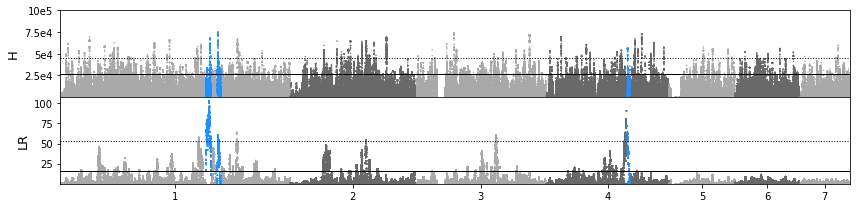

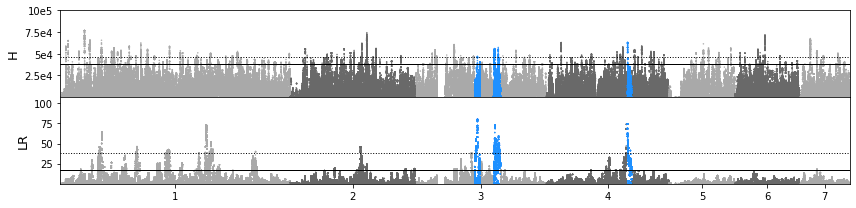

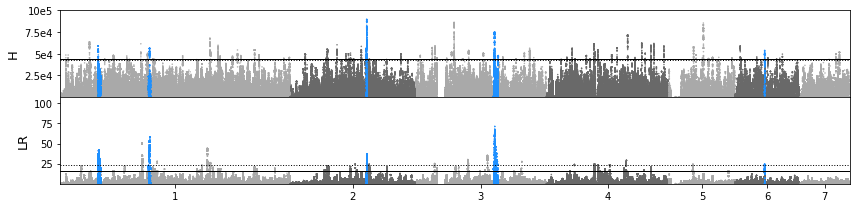

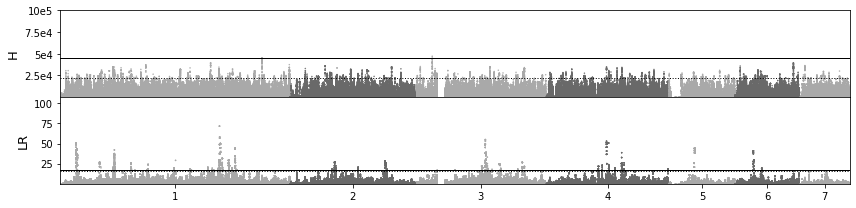

In [29]:
#for pop in ["brazil"]:
for pop in ["niger", "senegal", "brazil", "tanzania"]:

    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(12, 3)) #gridspec_kw={'hspace': 0.1}

    sdf=dfs[pop].loc[dfs[pop]["colors"] == colors["sig"]]
    ndf=dfs[pop].loc[dfs[pop]["colors"] != colors["sig"]]
    
    #plot each seperatley (so the sig points are on top)
    axs[0].scatter(ndf["x"], ndf["h"],         marker =".", s = 1, c = ndf['colors'])
    axs[1].scatter(ndf["x"], ndf["lr"],        marker =".", s = 1, c = ndf['colors'])
    #axs[2].scatter(ndf["x"], ndf["fst"],       marker =".", s = 1, c = ndf['colors'])
    #axs[3].scatter(ndf["x"], ndf["pi"],        marker =".", s = 1, c = ndf['colors'])
    #axs[4].scatter(ndf["x"], ndf["tajimas_d"], marker =".", s = 1, c = ndf['colors'])

    axs[0].scatter(sdf["x"], sdf["h"],         marker =".", s = 1, c = sdf['colors'])
    axs[1].scatter(sdf["x"], sdf["lr"],        marker =".", s = 1, c = sdf['colors'])
    #axs[2].scatter(sdf["x"], sdf["fst"],       marker =".", s = 1, c = sdf['colors'])
    #axs[2].scatter(sdf["x"], sdf["pi"],        marker =".", s = 1, c = sdf['colors'])
    #axs[4].scatter(sdf["x"], sdf["tajimas_d"], marker =".", s = 1, c = sdf['colors'])
    
    #set axes
    plt.xlim(0, scanned_size)
    axs[0].set_ylim( (0, h_ylim*1.05) )
    axs[1].set_ylim( (0, lr_ylim*1.05) )
    #axs[2].set_ylim( (0, fst_ylim*1.05) )
    #axs[3].set_ylim( (0, pi_ylim*1.05) )
    #axs[4].set_ylim( (tajimas_d_ymin*1.05, tajimas_d_ymax*1.05) )
        
    
    tick_lbls = [ "1", "2", "3", "4", "5", "6" ,"7"]
    plt.setp(axs, xticks=ticks, xticklabels=tick_lbls)

    axs[0].set_yticks(np.arange(25_000, 100_001, 25_000))
    axs[0].set_yticklabels(labels=["2.5e4", "5e4", "7.5e4", "10e5"])
    #axs[0].ticklabel_format(axis='y', style='sci')
    axs[0].set_ylabel("H", fontsize=13)

    
    axs[1].set_yticks(np.arange(25, 101, 25))
    axs[1].set_ylabel("LR", fontsize=13)

    #axs[2].set(ylabel="Fst")
    #axs[2].set(ylabel="Pi")
    #axs[4].set(ylabel="Tajima's D")
    #axs[0].ticklabel_format(axis='y', style='sci')


    #draw lines at...
    #...the max simulated value
    axs[0].axhline(y=max_h[pop],  color="black", linewidth=1)
    axs[1].axhline(y=max_lr[pop], color="black", linewidth=1)

    #...the 99th percentile
    target_percentile=0.99
    axs[0].axhline(y=np.percentile(dfs[pop]['h'],  target_percentile*100), linestyle=":", color="black", linewidth=1)
    axs[1].axhline(y=np.percentile(dfs[pop]['lr'], target_percentile*100), linestyle=":", color="black", linewidth=1)
    
    #set the title
    #title="{}".format(pop.title())
    #fig.suptitle(title)

    plt.tight_layout()
    #fig.savefig("results/selection_peaks/{}_selection.png".format(pop), dpi=300)
    #fig.savefig("results/selection_peaks/{}_selection.svg".format(pop)) 
    plt.show()
    plt.close()

# plot pcadapt

In [ ]:
df=pd.read_csv("results/outflank/pcadapt.csv", sep=',')

for index, row in tqdm(df.iterrows()):
    color = colors[row["chrom"]]
    x=cumul_start[row["chrom"]] + row["pos"]

    if row["sigs"] == True:
        color=colors["sig"]

#     if row["comps"] == 1.:
#         color="red"
#     if row["comps"] == 2.:
#         color="blue"

    df.at[index,'colors']= color
    df.at[index,'x'] = x
    
df

In [ ]:
plt.figure(figsize=(12, 3), dpi=300)

csig=df.loc[np.isfinite(df["comps"])]
cNaN=df.loc[np.isnan(df["comps"])]



plt.scatter(cNaN["x"], cNaN["logp"], alpha=1, s=6, color=cNaN["colors"], label="Non-outlier")
plt.scatter(csig["x"], csig["logp"], alpha=1, s=6, color=csig["colors"], label="Outlier")


#set axes
plt.xlim(0, scanned_size)
#plt.ylim( (0, df["logp"].max()*1.05) )

plt.legend(title="PCAdapt status", markerscale=4)

tick_lbls = [ "1", "2", "3", "4", "5", "6" ,"7"]
plt.xticks(ticks, labels=list(range(1,8)))
plt.ylabel("-log10($\it{q}$)", fontsize=13)
plt.xlabel("Chromosome", fontsize=13)
#plt.yscale("log")

plt.tight_layout()
#plt.savefig("results/selection_peaks/pcadapt.png", dpi=300)
#plt.savefig("results/selection_peaks/pcadapt.svg") 
plt.show()
plt.close()
    

In [ ]:
#fst of pcadapt sigs
sig=df.loc[df["sigs"]==True]["fst"]

#fst of pcadat insigs
insig=df.loc[df["sigs"]!=True]["fst"]

#plt.figure(figsize=(2, 2), dpi=300)
plt.boxplot([sig, insig],
            showfliers=True, 
            notch=False,
            labels=["True", "False"],
            medianprops=dict(color="black", lw=1))
plt.ylim(-0.1,1.1)
plt.xlabel("PCadapt outliers", fontsize=12)
plt.ylabel("Fst", fontsize=12)
#plt.savefig("results/pi/pi_boxplot_100kb_windows.svg")
#plt.savefig("results/pi/pi_boxplot_100kb_windows.png", dpi=300)
plt.show()

print("mean fst: Outliers = {:1f}, Remaining = {:1f}".format(sig.mean(), insig.mean()))

# Explore regions under selection

In [30]:
with open('results/selection_peaks/peaks.bed', 'w') as outfile:
    for pop in ["niger", "senegal", "brazil", "tanzania"]:
        with open( "results/selection_peaks/{}_target_regions.bed".format(pop), 'r') as infile:
            for entry in infile:
                entry=entry.rstrip()
                outfile.write("{}\t{}\n".format(entry, pop))

sig_regions_bed = pybedtools.BedTool('results/selection_peaks/peaks.bed')
print(sig_regions_bed)

SM_V7_1	56295674	58355356	niger
SM_V7_1	60733736	62145588	niger
SM_V7_4	31216154	32138352	niger
SM_V7_3	22786583	24999268	senegal
SM_V7_3	30092830	32970510	senegal
SM_V7_4	31216154	32881663	senegal
SM_V7_1	14832351	15772979	brazil
SM_V7_1	34234733	35105276	brazil
SM_V7_3	30092830	31936551	brazil
SM_V7_2	29220788	29604570	brazil
SM_V7_6	11468141	11631927	brazil



In [31]:
#avg peak size 
size=0
for chrom, start, stop, pop in sig_regions_bed:
    size+=int(stop)-int(start)+1

avg_size=size/len(sig_regions_bed)

print("avg peak size is {:.1f} bp".format(avg_size))

avg peak size is 1395643.4 bp


In [35]:
#intersect peaks wtih gff
gff = pybedtools.BedTool('data/genomes/Sm_v7.0.gff')

#intersecting_genes["brazil"]["snps"]=["gene1", "gene2"]
intersecting_genes=defaultdict(lambda: defaultdict(list))

#excluding tanzania cause there are no sig snps in that pop
for pop in ["niger", "senegal", "brazil"]:

    #intersect target regions with the genes gff
    regions_bed = pybedtools.BedTool("results/selection_peaks/{}_target_regions.bed".format(pop))
    intersect_regions_gff = gff.intersect(regions_bed, u=True)
    intersect_regions_gff.saveas("./results/selection_peaks/{}_target_regions_vs_genes.gff".format(pop))

    #intersect target SNPs with the genes gff
    sig_snps_bed = pybedtools.BedTool("results/selection_peaks/{}_sig_snps.bed".format(pop))
    intersect_snps_gff = gff.intersect(sig_snps_bed, u=True)
    intersect_snps_gff.saveas("./results/selection_peaks/{}_sig_snps_vs_genes.gff".format(pop))

    #create a gff database of genes intersecting target regions
    region_db = gffutils.create_db("./results/selection_peaks/{}_target_regions_vs_genes.gff".format(pop), 
                                    dbfn="results/selection_peaks/{}_target_regions_vs_genes.gff.db".format(pop),
                                    force=True, 
                                    keep_order=True, 
                                    merge_strategy='merge', 
                                    sort_attribute_values=True)

    #create a gff database of genes intersecting target genes
    snp_db = gffutils.create_db("./results/selection_peaks/{}_sig_snps_vs_genes.gff".format(pop), 
                            dbfn="results/selection_peaks/{}_sig_snps_vs_genes.gff.db".format(pop),
                            force=True, 
                            keep_order=True, 
                            merge_strategy='merge', 
                            sort_attribute_values=True)
    
    
    
    
    for i in region_db.features_of_type('gene'):
        intersecting_genes[pop]["region"].append(i["ID"][0])
    
    for i in snp_db.features_of_type('gene'):
        intersecting_genes[pop]["snp"].append(i["ID"][0])

In [36]:
with open ("results/selection_peaks/snp_genes_table.tsv", 'w') as snp_outfile:
    with open ("results/selection_peaks/region_genes_table.tsv", 'w') as region_outfile:

        for pop in ["niger", "senegal", "brazil"]:
            num_snp_genes    = str(len(intersecting_genes[pop]["snp"]))
            num_region_genes = str(len(intersecting_genes[pop]["region"]))
            print("{}: {} and {} genes in target regions and with target snps".format(pop, num_region_genes, num_snp_genes))

            intersecting_genes[pop]["snp"].sort()
            outline="\n".join([pop] + intersecting_genes[pop]["snp"])
            snp_outfile.write(outline + "\n")
        
            intersecting_genes[pop]["region"].sort()
            outline="\n".join([pop] + intersecting_genes[pop]["region"])
            region_outfile.write(outline + "\n")

niger: 121 and 5 genes in target regions and with target snps
senegal: 175 and 7 genes in target regions and with target snps
brazil: 126 and 10 genes in target regions and with target snps


In [37]:
pop_combos=list(itertools.combinations(["brazil", "senegal", "niger"], 2)) 

for pop1, pop2 in pop_combos:
    pop1_genes=set(intersecting_genes[pop1]["snp"])
    pop2_genes=set(intersecting_genes[pop2]["snp"])
    
    shared_genes=pop1_genes.intersection(pop2_genes)
    print("{} v {}: {} genes, {}".format(pop1, 
                                         pop2, 
                                         str(len(shared_genes)), 
                                         str(shared_genes)))

brazil v senegal: 1 genes, {'Smp_123520'}
brazil v niger: 0 genes, set()
senegal v niger: 2 genes, {'Smp_167890', 'Smp_313490'}


In [38]:
for pop1, pop2 in pop_combos:
    pop1_genes=set(intersecting_genes[pop1]["region"])
    pop2_genes=set(intersecting_genes[pop2]["region"])
    
    shared_genes=pop1_genes.intersection(pop2_genes)
    print("{} v {}: {} genes, {}".format(pop1, 
                                         pop2, 
                                         str(len(shared_genes)), 
                                         str(shared_genes)))

brazil v senegal: 50 genes, {'Smp_308830', 'Smp_347390', 'Smp_002640', 'Smp_002820', 'Smp_197370', 'Smp_300810', 'Smp_123470', 'Smp_123450', 'Smp_123530', 'Smp_326390', 'Smp_123500', 'Smp_002600', 'Smp_084540', 'Smp_123630', 'Smp_002510', 'Smp_123610', 'Smp_084520', 'Smp_123490', 'Smp_202130', 'Smp_002920', 'Smp_212320', 'Smp_123590', 'Smp_078750', 'Smp_123510', 'Smp_337740', 'Smp_164560', 'Smp_002870', 'Smp_123440', 'Smp_078730', 'Smp_341880', 'Smp_123640', 'Smp_308820', 'Smp_002880', 'Smp_123480', 'Smp_123570', 'Smp_021340', 'Smp_123460', 'Smp_123670', 'Smp_123620', 'Smp_002860', 'Smp_164590', 'Smp_123600', 'Smp_345510', 'Smp_123690', 'Smp_002740', 'Smp_002550', 'Smp_165280', 'Smp_002840', 'Smp_202120', 'Smp_123520'}
brazil v niger: 0 genes, set()
senegal v niger: 24 genes, {'Smp_114565', 'Smp_095680', 'Smp_345890', 'Smp_174580', 'Smp_169520', 'Smp_095630', 'Smp_341620', 'Smp_180240', 'Smp_313490', 'Smp_346220', 'Smp_313500', 'Smp_095670', 'Smp_169530', 'Smp_093850', 'Smp_204980', 'S

# Pi Genome-wide

In [199]:
#read in data
dfs={}
for pop in tqdm(['brazil', 'niger',  'senegal', 'tanzania']):
    dfs[pop]=pd.read_csv("results/selection_peaks/to_plot_{}.csv".format(pop), sep=",")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.58it/s]


In [250]:
pi_dfs={}
for pop in tqdm(['brazil', 'niger',  'senegal', 'tanzania', 'caribbean', 'rodhaini']):
    pi_dfs[pop]=pd.read_csv("results/pi/pi_boxplot_100kb_windows_{}.csv".format(pop),sep=",").dropna(subset=["pi"])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 112.47it/s]


In [251]:
for pop in ['brazil', 'niger',  'senegal', 'tanzania', 'caribbean', 'rodhaini']:
    pi=pi_dfs[pop]["pi"].dropna().mean()
    print("{}: {}".format(pop, pi))

brazil: 0.0006925911327382877
niger: 0.0005997772684642776
senegal: 0.0004968465614561425
tanzania: 0.0014511327938964362
caribbean: 0.0006274731680908758
rodhaini: 0.0005606783152180918


In [264]:
#get sig regions and calculate pi in vs out of those regions
regions_df = pd.read_table('results/selection_peaks/peaks.bed', sep="\t", header=None)
regions_df.columns=["chrom", "start", "stop", "pop"]


region_trees=defaultdict(lambda: defaultdict( lambda: IntervalTree()))

for index, row in regions_df.iterrows():
    pop=row["pop"]
    chrom=row["chrom"]
    start=row["start"]
    stop=row["stop"]
    region_trees[pop][chrom][start : stop] = "significant"

In [325]:
sig_pis=defaultdict(lambda: [])
nsig_pis=defaultdict(lambda: [])
sig_pi_df=pd.DataFrame(columns=list(pi_dfs["brazil"].columns) + ["pop"])

#now for each pi subset if it is in the tree or not
for pop in ['brazil', 'niger',  'senegal', 'tanzania', 'caribbean', 'rodhaini']:

    df=pi_dfs[pop]
    
    for index, row in df.iterrows():
        pi=row["pi"]
        chrom=row["chrom"]
        start=row["start"]
        stop=row["stop"]
        row["pop"] = pop
        
        if region_trees[pop][chrom][start : stop] == set():
            nsig_pis[pop].append(pi)
        else:
            sig_pis[pop].append(pi)
            sig_pi_df=sig_df.append(row)

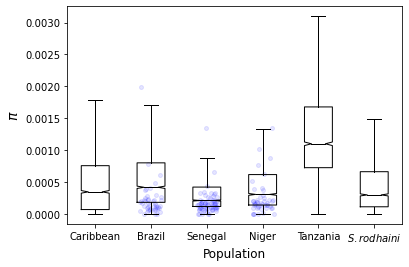

In [356]:
x_pos={"caribbean" : 1,
       "brazil"    : 2,
       "senegal"   : 3,
       "niger"     : 4,
       "tanzania"  : 5,
       "rodhaini"  : 6 }

for index, row in sig_pi_df.iterrows():
    x=x_pos[row["pop"]]
    y=row["pi"]
    
    #add jitter
    x=x+random.uniform(-0.2, 0.2)
    
    plt.plot(x, y, 'b.', markersize=8, alpha=0.1)
    
plt.boxplot([ pi_dfs["caribbean"].dropna(subset=["pi"])["pi"],
              pi_dfs["brazil"].dropna(subset=["pi"])["pi"],
              pi_dfs["senegal"].dropna(subset=["pi"])["pi"],
              pi_dfs["niger"].dropna(subset=["pi"])["pi"], 
              pi_dfs["tanzania"].dropna(subset=["pi"])["pi"],
              pi_dfs["rodhaini"].dropna(subset=["pi"])["pi"] ],
             showfliers=False, 
             notch=True,
             labels=["Caribbean", "Brazil", "Senegal", "Niger", "Tanzania", "$\it{S. rodhaini}$"],
             medianprops=dict(color="black", lw=1) )

plt.xlabel("Population", fontsize=12)
plt.ylabel("$\pi$", fontsize=14)
#plt.yscale("log")
#plt.savefig("results/pi/pi_boxplot_100kb_windows_wsig.svg")
#plt.savefig("results/pi/pi_boxplot_100kb_windows_wsigs.png", dpi=300)
plt.show()

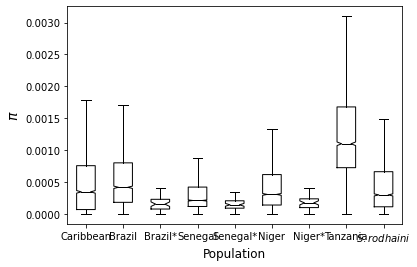

In [347]:
plt.boxplot([ pi_dfs["caribbean"].dropna(subset=["pi"])["pi"],
              pi_dfs["brazil"].dropna(subset=["pi"])["pi"],
              sig_pi_df.loc[sig_pi_df["pop"] == "brazil"]["pi"],
              pi_dfs["senegal"].dropna(subset=["pi"])["pi"],
              sig_pi_df.loc[sig_pi_df["pop"] == "senegal"]["pi"],
              pi_dfs["niger"].dropna(subset=["pi"])["pi"], 
              sig_pi_df.loc[sig_pi_df["pop"] == "niger"]["pi"],
              pi_dfs["tanzania"].dropna(subset=["pi"])["pi"],
              pi_dfs["rodhaini"].dropna(subset=["pi"])["pi"] ],
             showfliers=False, 
             notch=True,
             labels=["Caribbean", "Brazil", "Brazil*", "Senegal", "Senegal*", "Niger", "Niger*", "Tanzania", "$\it{S. rodhaini}$"],
             medianprops=dict(color="black", lw=1) )

plt.xlabel("Population", fontsize=12)
plt.ylabel("$\pi$", fontsize=14)
#plt.yscale("log")
#plt.savefig("results/pi/pi_boxplot_100kb_windows_wsigboxes.svg")
#plt.savefig("results/pi/pi_boxplot_100kb_windows_wsigboxes.png", dpi=300)
plt.show()

In [355]:
print("pop, all_pi_mean, sig_pi_mean, t, p")
    
for pop in ["brazil", "niger", "senegal"]:
    spi=sig_pi_df.loc[sig_pi_df["pop"] == pop]["pi"]
    api=pi_dfs[].dropna(subset=["pi"])["pi"]
    t, p = stats.ttest_ind(spi, api, equal_var=False)
    
    
    print("{}, {}, {}, {}, {}".format(pop,
                                      api.mean(),
                                      spi.mean(),
                                      t,
                                      p) )

pop, all_pi_mean, sig_pi_mean, t, p
brazil, 0.0006925911327382877, 0.00022224333460848123, -9.416231788772604, 8.938591091307505e-14
niger, 0.0005997772684642776, 0.00024586149501158033, -7.91917194086271, 2.1397008531879e-11
senegal, 0.0004968465614561425, 0.00017477014772342917, -11.184868001573586, 3.436892382982485e-23


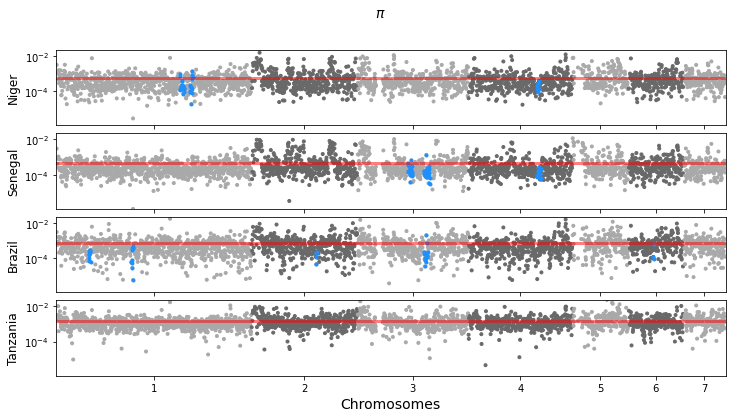

In [421]:
#get ylims from pis
pis=np.array([])
for pop in ["brazil", "tanzania", "niger", "senegal"]:
    pis=np.append(pis, pi_dfs[pop]["pi"])
    
min_pi=pis[pis>0].min()
max_pi=pis[pis>0].max()

#set up figure
fig, axs = plt.subplots(4, sharex=True, gridspec_kw={'hspace': 0.1}, figsize=(12, 6)) #gridspec_kw={'hspace': 0.1}

#plot scatter for pi and each pop
i=0
for pop in ["niger", "senegal", "brazil", "tanzania"]:

    ########################
    # normal pi
    ########################
    #add info for figure including x position and the point color
    cs=[]
    xs=[]
    for index, row in pi_dfs[pop].iterrows():
        pos=(row["start"] + row["stop"])/2
        cs.append(colors[row["chrom"]])
        xs.append(cumul_start[row["chrom"]] + pos)

    #get data without missing values
    pis=pi_dfs[pop]["pi"]
    
    #plot
    axs[i].scatter(xs, pis, marker =".", c = cs)

    #add line at mean pi
    axs[i].axhline(y=pis.mean(), xmin=0, xmax=scanned_size, color="red", linewidth=3, alpha=0.5)
    
    
    ########################
    # sig pi
    ########################
    xs=[]
    spi_df=sig_pi_df.loc[sig_pi_df["pop"] == pop]
    
    for index, row in spi_df.iterrows():
        pos=(row["start"] + row["stop"])/2
        xs.append(cumul_start[row["chrom"]] + pos)
        
    spis=spi_df["pi"]
    axs[i].scatter(xs, spis, marker =".", c = "dodgerblue")
               
    #make the axis labeling
    axs[i].set_ylabel("{}".format(pop.title()), fontsize=12)
    axs[i].set_yscale('log')
    axs[i].set_ylim(min_pi,max_pi)
   
    #increment to the next population (and subplot)
    i=i+1
    
# #add tick 
tick_lbls = [ "1", "2", "3", "4", "5", "6" ,"7"]
plt.setp(axs, xticks=ticks, xticklabels=tick_lbls)

# #set xlims
plt.xlim(0, scanned_size)
plt.xlabel("Chromosomes", fontsize=14)

# #set the title
title="$\pi$"
fig.suptitle(title, fontsize=14)
    
# #plt.tight_layout()

fig.savefig("results/selection_peaks/pi_across_the_genome.png".format(pop), dpi=300)
# #fig.savefig("results/selection_peaks/pi_across_the_genome.svg".format(pop)) 
plt.show()
plt.close()

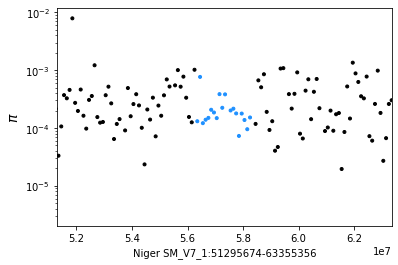

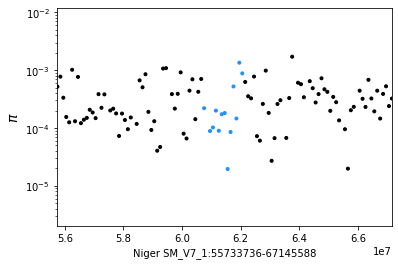

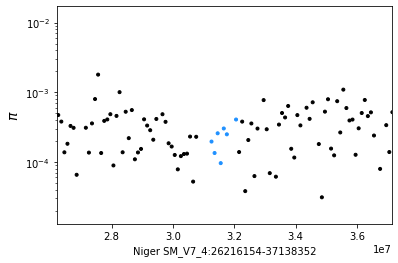

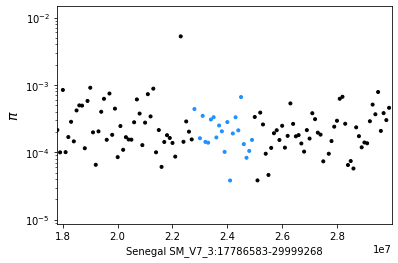

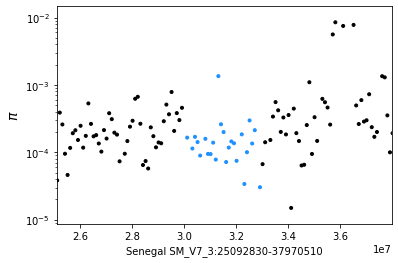

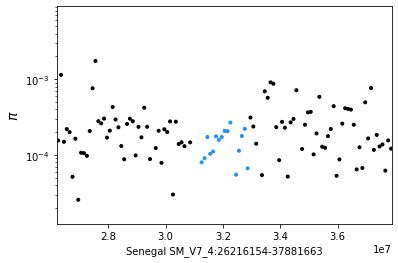

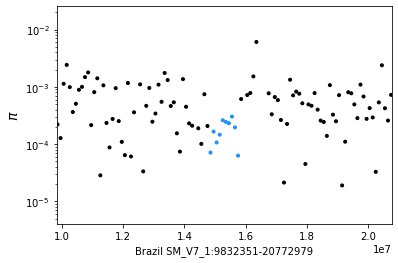

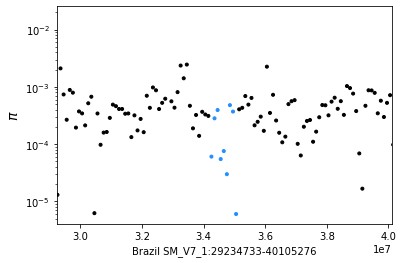

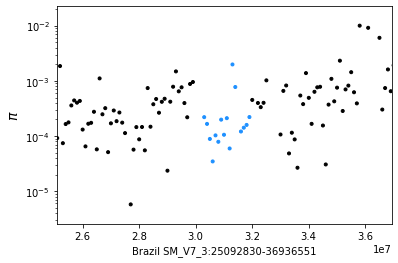

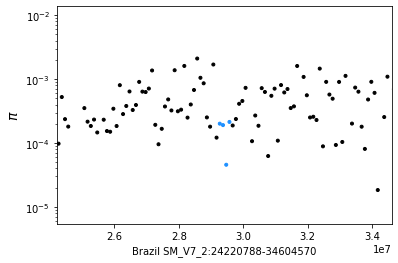

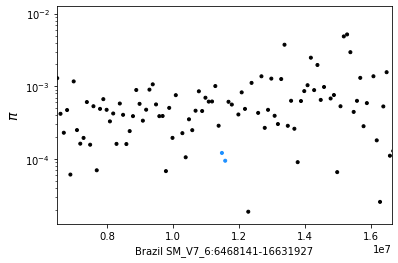

In [488]:
#zoom in on sig regions
buffer=5_000_000

#get sig regions and calculate pi in vs out of those regions
regions_df = pd.read_table('results/selection_peaks/peaks.bed', sep="\t", header=None)
regions_df.columns=["chrom", "start", "stop", "pop"]

xs=[]
i=0

#fig, axs = plt.subplots(len(regions_df), gridspec_kw={'hspace': 0.1}, figsize=(12, 6)) #gridspec_kw={'hspace': 0.1}

for index, row in regions_df.iterrows():
        start=row["start"]
        stop=row["stop"]
        chrom=row["chrom"]
        pop=row["pop"]

        df=pi_dfs[pop].loc[pi_dfs[pop]["chrom"] == chrom]
        pis=df["pi"]
        xs=(df["start"] + df["stop"])/2
        
        #set colors
        c=np.array(["dodgerblue"]*len(xs))
        c[xs<start] = "black"
        c[xs>stop] = "black"
        
        plt.scatter(xs, pis, marker =".", c = c)
        #plt.plot(xs, pis)
        #get xlims based on a buffer
        plt.xlim(start-buffer, stop+buffer)
        
        label_str="{} {}:{}-{}".format(pop.title(), chrom, start-buffer, stop+buffer)
        plt.xlabel(label_str)
        plt.ylabel("$\pi$", fontsize=14)
        
        plt.yscale('log')
        
        
        #get data from normal chrom
        i=i+1
        plt.show()

In [475]:
# compare sig regions to same regions in west africa and other pops

In [494]:
dfs=[]
for pop in ["brazil", "tanzania", "niger", "senegal"]:
    dfs[pop]=pd.read_csv("results/selection_peaks/to_plot_{}.csv".format(pop), sep=",")


TypeError: list indices must be integers or slices, not str

In [497]:
!head results/selection_peaks/to_plot_brazil.csv

chrom,pos,h,lr,pi,tajimas_d,colors,x
SM_V7_1,302288,0.0,0.296891,NULL,NULL,darkgrey,302288.0
SM_V7_1,705190,163.895,0.958193,NULL,NULL,darkgrey,705190.0
SM_V7_1,705210,164.2,0.958193,NULL,NULL,darkgrey,705210.0
SM_V7_1,705322,155.348,0.586511,NULL,NULL,darkgrey,705322.0
SM_V7_1,705337,123.933,0.586511,NULL,NULL,darkgrey,705337.0
SM_V7_1,705340,119.035,0.586511,NULL,NULL,darkgrey,705340.0
SM_V7_1,705343,124.51,0.586511,NULL,NULL,darkgrey,705343.0
SM_V7_1,705389,108.507,0.586511,NULL,NULL,darkgrey,705389.0
SM_V7_1,705395,60.0293,0.586511,NULL,NULL,darkgrey,705395.0


In [496]:
pi_dfs

{'brazil':             pi       start        stop  n_bases  n_snps    chrom
 0     0.003026    302288.0    402287.0    167.0     1.0  SM_V7_1
 4     0.000578    702288.0    802287.0   1087.0    14.0  SM_V7_1
 7     0.000884   1002288.0   1102287.0   1186.0    63.0  SM_V7_1
 8     0.001589   1102288.0   1202287.0   1413.0    35.0  SM_V7_1
 9     0.000849   1202288.0   1302287.0   1879.0     9.0  SM_V7_1
 ...        ...         ...         ...      ...     ...      ...
 3020  0.001269  18610060.0  18710059.0   5888.0   216.0  SM_V7_7
 3021  0.000565  18710060.0  18810059.0   6616.0   339.0  SM_V7_7
 3022  0.000488  18810060.0  18910059.0   4802.0   221.0  SM_V7_7
 3023  0.000597  18910060.0  19010059.0   4947.0   173.0  SM_V7_7
 3024  0.000124  19010060.0  19087225.0   3448.0   100.0  SM_V7_7
 
 [2838 rows x 6 columns],
 'niger':             pi       start        stop  n_bases  n_snps    chrom
 0     0.003152    302288.0    402287.0    167.0     1.0  SM_V7_1
 4     0.001063    702288.0  

In [489]:
regions_df

,chrom,start,stop,pop
0,SM_V7_1,56295674,58355356,niger
1,SM_V7_1,60733736,62145588,niger
2,SM_V7_4,31216154,32138352,niger
3,SM_V7_3,22786583,24999268,senegal
4,SM_V7_3,30092830,32970510,senegal
5,SM_V7_4,31216154,32881663,senegal
6,SM_V7_1,14832351,15772979,brazil
7,SM_V7_1,34234733,35105276,brazil
8,SM_V7_3,30092830,31936551,brazil
9,SM_V7_2,29220788,29604570,brazil


In [442]:
#df=pi_dfs[pop].loc[pi_dfs[pop]["chrom"] == chrom]
df

,pi,start,stop,n_bases,n_snps,chrom
2591,0.001151,327295.0,427294.0,975.0,63.0,SM_V7_6
2595,0.000055,727295.0,827294.0,1173.0,13.0,SM_V7_6
2596,0.000353,827295.0,927294.0,3839.0,84.0,SM_V7_6
2597,0.000372,927295.0,1027294.0,4948.0,159.0,SM_V7_6
2598,0.000659,1027295.0,1127294.0,2688.0,123.0,SM_V7_6
...,...,...,...,...,...,...
2832,0.000315,24427295.0,24527294.0,7086.0,252.0,SM_V7_6
2834,0.000880,24627295.0,24727294.0,5293.0,198.0,SM_V7_6
2835,0.000491,24727295.0,24827294.0,5704.0,275.0,SM_V7_6
2836,0.000447,24827295.0,24927294.0,2433.0,99.0,SM_V7_6


In [410]:
#get ylims from pis
pis=np.array([])
for pop in ["brazil", "tanzania", "niger", "senegal"]:
    pis=np.append(pis, pi_dfs[pop]["pi"])
    
min_pi=pis[pis>0].min()
max_pi=pis[pis>0].max()

#set up figure
fig, axs = plt.subplots(4, sharex=True, gridspec_kw={'hspace': 0.1}, figsize=(12, 6)) #gridspec_kw={'hspace': 0.1}

#plot scatter for pi and each pop
i=0
for pop in ["niger", "senegal", "brazil", "tanzania"]:

    ########################
    # normal pi
    ########################
    #add info for figure including x position and the point color
    cs=[]
    xs=[]
    for index, row in pi_dfs[pop].iterrows():
        pos=(row["start"] + row["stop"])/2
        cs.append(colors[row["chrom"]])
        xs.append(cumul_start[row["chrom"]] + pos)

    #get data without missing values
    pis=pi_dfs[pop]["pi"]
    
    #plot
    axs[i].scatter(xs, pis, marker =".", c = cs)

    #add line at mean pi
    axs[i].axhline(y=pis.mean(), xmin=0, xmax=scanned_size, color="red", linewidth=3, alpha=0.5)
    
    
    ########################
    # sig pi
    ########################
    xs=[]
    spi_df=sig_pi_df.loc[sig_pi_df["pop"] == pop]
    
    for index, row in spi_df.iterrows():
        pos=(row["start"] + row["stop"])/2
        xs.append(cumul_start[row["chrom"]] + pos)
        
    spis=spi_df["pi"]
    axs[i].scatter(xs, spis, marker =".", c = "dodgerblue")
               
    #make the axis labeling
    axs[i].set_ylabel("{}".format(pop.title()), fontsize=12)
    axs[i].set_yscale('log')
    axs[i].set_ylim(min_pi,max_pi)
   
    #increment to the next population (and subplot)
    i=i+1
    
# #add tick 
tick_lbls = [ "1", "2", "3", "4", "5", "6" ,"7"]
plt.setp(axs, xticks=ticks, xticklabels=tick_lbls)

# #set xlims
plt.xlim(0, scanned_size)
plt.xlabel("Chromosomes", fontsize=14)

# #set the title
title="$\pi$"
fig.suptitle(title, fontsize=14)
    
# #plt.tight_layout()

fig.savefig("results/selection_peaks/pi_across_the_genome.png".format(pop), dpi=300)
# #fig.savefig("results/selection_peaks/pi_across_the_genome.svg".format(pop)) 
plt.show()
plt.close()

0.0014511327938964362

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.08s/it]


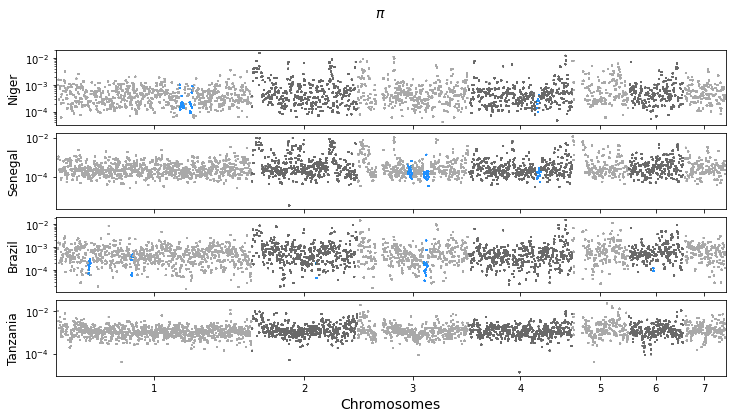

In [219]:
#set up figure
fig, axs = plt.subplots(4, sharex=True, gridspec_kw={'hspace': 0.1}, figsize=(12, 6)) #gridspec_kw={'hspace': 0.1}

#plot scatter for pi and each pop
i=0
for pop in tqdm(["niger", "senegal", "brazil", "tanzania"]):

    #get data without missing values
    df=dfs[pop].dropna()

    #plot
    axs[i].scatter(df["x"], df["pi"], marker =".", s = 1, c = df['colors'])

    #make the axis labeling
    #axs[0].ticklabel_format(axis='y', style='sci')
    axs[i].set_ylabel("{}".format(pop.title()), fontsize=12)
    axs[i].set_yscale('log')
    
    #increment to the next population (and subplot)
    i=i+1
    
#add tick 
tick_lbls = [ "1", "2", "3", "4", "5", "6" ,"7"]
plt.setp(axs, xticks=ticks, xticklabels=tick_lbls)

#set xlims
plt.xlim(0, scanned_size)
plt.xlabel("Chromosomes", fontsize=14)
#set the title
title="$\pi$"
fig.suptitle(title, fontsize=14)
    
#plt.tight_layout()

#fig.savefig("results/selection_peaks/pi_across_the_genome.png".format(pop), dpi=300)
#fig.savefig("results/selection_peaks/pi_across_the_genome.svg".format(pop)) 
plt.show()
plt.close()
    

In [238]:
for pop in ["pop="niger"
df=dfs[pop].dropna(subset=["pi"])

In [238]:
df.loc[df["colors"] == colors["sig"]]["pi"].mean()

0.00021859276556098462

In [239]:
df.loc[df["colors"] != colors["sig"]]["pi"].mean()

0.0005764752415999917

## Pi in regions of interest vs. others.

In [42]:
#read in bed file
sig_regions_bed_df = pd.read_table('results/selection_peaks/peaks.bed', sep="\t", header=None)
sig_regions_bed_df.columns=["chrom", "start", "stop", "pop"]
sig_regions_bed_df

,chrom,start,stop,pop
0,SM_V7_1,56295674,58355356,niger
1,SM_V7_1,60733736,62145588,niger
2,SM_V7_4,31216154,32138352,niger
3,SM_V7_3,22786583,24999268,senegal
4,SM_V7_3,30092830,32970510,senegal
5,SM_V7_4,31216154,32881663,senegal
6,SM_V7_1,14832351,15772979,brazil
7,SM_V7_1,34234733,35105276,brazil
8,SM_V7_3,30092830,31936551,brazil
9,SM_V7_2,29220788,29604570,brazil


In [43]:
with open('data/pop_assign.yml') as yaml_file:
    pop_assign = yaml.load(yaml_file, Loader=yaml.FullLoader)

In [44]:
#-------------------------------------------------------------------------------
# get genotype info per population

#read in vcf
filtered_callset=allel.read_vcf('results/variant_filtration/smv7_ex_autosomes.vcf')

#now get an index for each sample/population
samples = filtered_callset["samples"]

i=0
pop_idxs = defaultdict(list)   
for sample in samples:  
    pop_idxs[pop_assign[sample]].append(i) 
    i=i+1

pops= list(pop_idxs.keys()) 

#get genotypes
gt=allel.GenotypeArray(filtered_callset['calldata/GT'])

#now get allele count per population
ac=gt.count_alleles()

pop_ac={}
for pop in pops:
    pop_ac[pop] = gt.count_alleles(subpop=pop_idxs[pop])

In [45]:
#initialize an list the lenght of each contig to fale
accessible_bases = {}
chrom_length = {}

with open('data/genomes/Smansoni_v7.fa.fai', 'r') as fai:
    for entry in fai:
        chrom, length, *offset = entry.rstrip().split("\t")
        chrom_length[chrom] = int(length)
        accessible_bases[chrom]=[False] * int(length)


#now read the bed
with open('data/renamed-sma_agilent_baits.v7.0.chr_reorderd.bed', 'r') as in_bed_file:
    for bed_entry in in_bed_file:
        chrom, start, stop = bed_entry.rstrip().split("\t")
        for base in range(int(start) - 1, int(stop)):
             accessible_bases[chrom][base]=True


In [47]:
pi_s=[]
#accessible_base_count_s=[]

for index, row in sig_regions_bed_df.iterrows():
    chrom =row["chrom"]
    start = row["start"]
    stop  = row["stop"]
    
    #calculate pi
    test_ac  = pop_ac[pop][filtered_callset['variants/CHROM'] == chrom]
    test_pos = filtered_callset['variants/POS'][filtered_callset['variants/CHROM'] == chrom]
    test_acc = accessible_bases[chrom]
    
    pi = allel.sequence_diversity(test_pos, 
                                  test_ac, 
                                  start=start, 
                                  stop=stop, 
                                  is_accessible=test_acc)
    pi_s.append(pi)
    #np.sum(test_acc[start:stop]) 

sig_regions_bed_df["pi"]=pi_s
sig_regions_bed_df.to_csv("sig_regions_pi.csv", sep=",")
sig_regions_bed_df

,chrom,start,stop,pop,pi
0,SM_V7_1,56295674,58355356,niger,0.001018
1,SM_V7_1,60733736,62145588,niger,0.000574
2,SM_V7_4,31216154,32138352,niger,0.000918
3,SM_V7_3,22786583,24999268,senegal,0.001378
4,SM_V7_3,30092830,32970510,senegal,0.001052
5,SM_V7_4,31216154,32881663,senegal,0.001094
6,SM_V7_1,14832351,15772979,brazil,0.000965
7,SM_V7_1,34234733,35105276,brazil,0.000592
8,SM_V7_3,30092830,31936551,brazil,0.001184
9,SM_V7_2,29220788,29604570,brazil,0.001077


In [92]:
pi_dfs={}

for pop in ["brazil", "senegal", "niger", "tanzania", "caribbean", "rodhaini"]:
    pi_dfs[pop] =pd.read_csv("results/pi/pi_boxplot_100kb_windows_{}.csv".format(pop), sep=",")

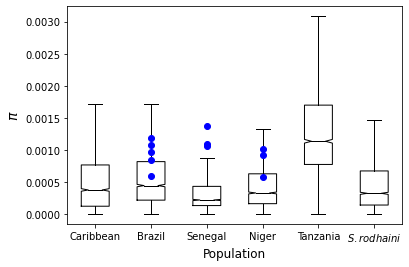

In [96]:
plt.boxplot([pi_dfs["caribbean"][pi_dfs["caribbean"]["n_snps"]>25]["pi"],
             pi_dfs["brazil"][pi_dfs["brazil"]["n_snps"]>25]["pi"],
             pi_dfs["senegal"][pi_dfs["senegal"]["n_snps"]>25]["pi"],
             pi_dfs["niger"][pi_dfs["niger"]["n_snps"]>25]["pi"], 
             pi_dfs["tanzania"][pi_dfs["tanzania"]["n_snps"]>25]["pi"],
             pi_dfs["rodhaini"][pi_dfs["rodhaini"]["n_snps"]>25]["pi"]],
            showfliers=False, 
            notch=True,
            labels=["Caribbean", "Brazil", "Senegal", "Niger", "Tanzania", "$\it{S. rodhaini}$"],
            medianprops=dict(color="black", lw=1))
plt.xlabel("Population", fontsize=12)
plt.ylabel("$\pi$", fontsize=14)


x_pos={"caribbean" : 1,
       "brazil"    : 2,
       "senegal"   : 3,
       "niger"     : 4,
       "tanzania"  : 5,
       "rodhaini"  : 6 }

for index, row in sig_regions_bed_df.iterrows():
    x=x_pos[row["pop"]]
    y=row["pi"]
    plt.plot(x, y, 'b.', markersize=12)
#plt.savefig("results/pi/pi_boxplot_100kb_windows_wpeaks.svg")
#plt.savefig("results/pi/pi_boxplot_100kb_windows_wpeaks.png", dpi=300)
plt.show()

In [98]:
#re-add pi_trees
dfs={}
pis={}

for pop in sig_regions_bed_df["pop"].unique():
    #print(pop)
    
    # LOAD PI TREES
    #designate files and read into dfs
    pi_file    = "results/pi/pi_boxplot_100kb_windows_{}.csv".format(pop)
    
    #read in to dfs    
    pi_df    = pd.read_csv(pi_file, sep=",").dropna()
   
    #create empty interval trees to store the data
    pi_trees=defaultdict(lambda: IntervalTree())

    #for each stat, add the values to the interval tree
    for index, row in pi_df[pi_df["n_snps"]>25].iterrows():
         pi_trees[row["chrom"]][row["start"]: row["stop"]] = row["pi"]   
            
   #now get pi 2.5 and 97.5th percentiles
    pis=list(pi_df.dropna()["pi"])
    top=stats.scoreatpercentile(pis, 97.5)
    bottom=stats.scoreatpercentile(pis, 2.5)

    
    #now get sig regions for this pop
    df = sig_regions_bed_df.loc[sig_regions_bed_df["pop"] == pop]


In [101]:
for index, row in df.iterrows():
    chrom = row["chrom"]
    start = row["start"]
    stop = row["stop"]
    #pi_trees[chrom][start: stop]   

In [102]:
pi_trees[chrom][start: stop]   

{Interval(11427295.0, 11527294.0, 0.0001211085716625),
 Interval(11527295.0, 11627294.0, 9.457895097928676e-05),
 Interval(11627295.0, 11727294.0, 0.0006128269677566)}

In [111]:
chroms = filtered_callset['variants/CHROM']
pos = filtered_callset['variants/POS']



In [108]:
windows=allel.equally_accessible_windows(accessible_bases["SM_V7_1"], 100)    

In [114]:
len(windows)

8112

In [115]:
len(chr_pos)

162219

In [119]:
chr_pos = pos[chroms == "SM_V7_1"]

In [121]:
pop_ac["brazil"][chroms == "SM_V7_1"]

<AlleleCountsArray shape=(162219, 2) dtype=int32>
46 44
71  3
77  1
...
80  0
80  0
62  0

/tmp/ipykernel_30238/898789741.py:24: RuntimeWarning: divide by zero encountered in log10
  plt.boxplot(-np.log10(pi))
/master/nplatt/sch_man_nwinvasion/envs/sch_man_nwinvasion-selection/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


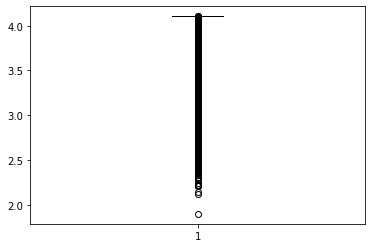

In [192]:
pop = "niger"
chrom = "SM_V7_1"
start = 14_832_351
stop = 15_772_979

chr_win =allel.equally_accessible_windows(accessible_bases[chrom], 250)    
chr_pos = pos[chroms == chrom]
chr_ac  = pop_ac[pop][chroms == chrom]

pi, windows, n_bases, counts = allel.windowed_diversity(chr_pos, chr_ac, windows=chr_win)

#filter with few snps
pi=pi[counts>10]
windows=windows[counts>10]
n_bases=n_bases[counts>10]
counts=counts[counts>10]

#smoothed_pi=scipy.signal.medfilt(pi, 9)

#plot
xs = (windows[:,0] + windows[:,1])/2

#plt.scatter(xs, -np.log10(smoothed_pi))
plt.boxplot(-np.log10(pi))
#plt.xlim(start, stop)
#plt.ylim(0, 0.001)
plt.show()

(array([ 12., 232., 499., 677., 388., 461., 315., 169.,  52.,  12.]),
 array([1.89854236, 2.3149151 , 2.73128784, 3.14766059, 3.56403333,
        3.98040607, 4.39677881, 4.81315155, 5.2295243 , 5.64589704,
        6.06226978]),
 <BarContainer object of 10 artists>)

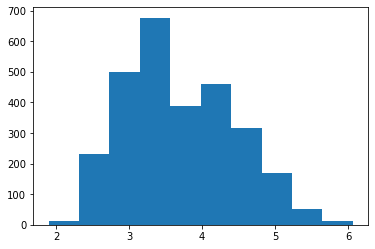

In [194]:
pi=pi[pi>0]
plt.hist(-np.log10(pi))

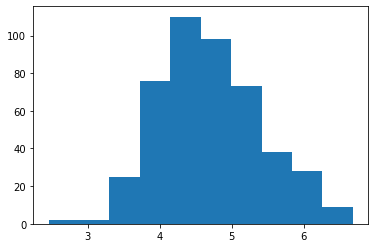

brazil: 7.447040924791032e-05


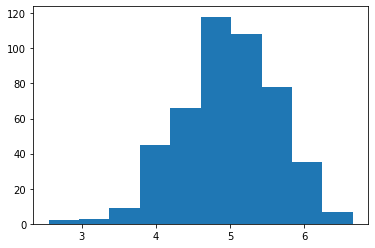

senegal: 6.560840708436562e-05


KeyboardInterrupt: 

In [196]:
pis=np.array([])
for pop in ["brazil", "senegal", "niger", "tanzania", "caribbean", "rodhaini"]:
    for chrom in ["SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7"]:

        chr_win =allel.equally_accessible_windows(accessible_bases[chrom], 1_000)    
        chr_pos = pos[chroms == chrom]
        chr_ac  = pop_ac[pop][chroms == chrom]

        pi, windows, n_bases, counts = allel.windowed_diversity(chr_pos, chr_ac, windows=chr_win)
        
        #filter with few snps
        pi=pi[counts>0]
        pis=np.append(pis, pi)        
    
    pi=pi[pi>0]
    plt.hist(-np.log10(pi))
    plt.show()
    pi=pis.mean()
    print("{}: {}".format(pop, pi))

In [ ]:
pi=pi[pi>0]
plt.hist(-np.log10(pi))

In [177]:
#250
brazil: 0.0003570902837041917
senegal: 0.00031926531937544785
niger: 0.00031353330658589264
tanzania: 0.0004228094247386543
caribbean: 0.0004004911153774926
rodhaini: 0.00038259898957267445

0

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([[  103114,   103213],
        [  103214,   103313],
        [  103314,   103472],
        ...,
        [88796894, 88796993],
        [88796994, 88797093],
        [88797094, 88797193]]),
 array([100, 100, 159, ..., 100, 100, 100]),
 array([ 0,  0,  0, ..., 11,  7,  6]))

In [86]:
pi_conf_ints={}

for pop in ["tanzania", "senegal", "brazil", "niger"]:
    #print(pop)
    
    #designate files and read into dfs
    pi_file    = "results/pi/pi_boxplot_100kb_windows_{}.csv".format(pop)
    
    #read in to dfs    
    pi_df    = pd.read_csv(pi_file, sep=",").dropna()
    
    
    pis=list(pi_df.dropna()["pi"])
    top=stats.scoreatpercentile(pis, 97.5)
    bottom

0.003703535729532882

In [ ]:
stats.scoreatpercentile(pis, 97.5)
